# Result Summary - Status Reporting 1 - Ref

***
**Delay**
<br>62.3s
<br>**Reliability**
<br>92.2%
<br>**Energy Consumption**
<br>804.8 mC
<br>40.0 mW
***
The calculations are based on 10k data.
Considering the large file size, the power profiler data upload to the GitHub repo is part of the raw file (50M, for 17s time duration).
You can do the anlaysis again with your analysis code and check the performance metrics.

In [1]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from pylab import rcParams
from functions import *

rcParams["figure.figsize"] = 16, 4

PACKET_LEN = 32  # (in Bytes) packet payload length defined by the transmitter
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq
NO_PACKET = int(np.ceil(10*1024/PACKET_LEN))

In [2]:
# define the file name
filename = "log"
# import file to jupyter notebook
df = readfile("./" + filename + ".csv")

# check the imported data first 10 lines
df.head(10)

,seq,time_tx,time_rx,payload,rssi
0,0,15129,56715536,2f c2 39 44 d3 16 7d b8 b7 aa 01 6c db 7e c5 6...,-52
1,1,27295,56727225,3c 6b ce d5 30 cf e2 d9 64 73 36 1d d8 57 ca a...,-51
2,3,51710,56752617,56 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 2...,-52
3,5,76125,56776055,70 0f 22 19 a4 b3 76 5d 18 97 0a e1 cc bb de a...,-51
4,6,88332,56788751,7d b8 b7 aa 01 6c db 7e c5 60 3f 92 c9 94 e3 e...,-51
5,7,100540,56800470,8a 61 4c 3b 5e 25 40 9f 72 29 74 43 c6 6d e8 2...,-50
6,8,112747,56812189,97 0a e1 cc bb de a5 c0 1f f2 a9 f4 c3 46 ed 6...,-50
7,9,124954,56824885,a4 b3 76 5d 18 97 0a e1 cc bb de a5 c0 1f f2 a...,-49
8,10,137162,56838557,b1 5c 0b ee 75 50 6f 02 79 84 13 56 bd f8 f7 e...,-50
9,11,149369,56847840,be 05 a0 7f d2 09 d4 23 26 4d 48 07 ba d1 fc 2...,-50


In [3]:
# replace the resettable seq number to unresettable, for the purpose of reliability calculation
test = replace_seq(df.copy(), MAX_SEQ=256)
test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

In [4]:
file_end_index = test.index[test.seq == test.seq[0] + NO_PACKET][0]
test = test.iloc[:file_end_index,:]

# Delay

In [5]:
# compute the file delay
file_delay = test.time_rx[len(test) - 1] - test.time_rx[0]
print(f"The time it takes to transfer the file is : {file_delay} (ticks with rtimer).")
# RTIMER_TIMER at 62500Hz. Generates 1 tick per exactly 16 usecs,
print(f"The time it takes to transfer the file is : {file_delay/62500} (seconds with rtimer).")

The time it takes to transfer the file is : 3895118 (ticks with rtimer).
The time it takes to transfer the file is : 62.321888 (seconds with rtimer).


# Reliability

In [6]:
# compute the BER for all received packets
ber, error = compute_ber(test, PACKET_LEN=32, MAX_SEQ=MAX_SEQ)
print(f"Bit reliability: {1-ber}")

320
     seq bit_errors
0      0        [0]
1      1        [0]
2      2         []
3      3        [0]
4      4         []
..   ...        ...
315  315        [0]
316  316        [0]
317  317        [0]
318  318        [0]
319  319        [0]

[320 rows x 2 columns]
Bit reliability: 0.921875


# Energy Consumption

In [8]:
# load ppk data for the transmitter
energy_tx = pd.read_csv("./ppk.csv")

# check the imported data first 10 lines
energy_tx.head(10)

# discard the board initiation status
tmp = energy_tx[energy_tx['Current(uA)'] > 20e3].index
energy_tx = energy_tx.iloc[tmp[0]:,:]

In [9]:
# the voltage (controlled by the PPK2, in the example log we set it as 3000 mV)
voltage = 3000 / 1e3  # mV to V

# the power consumption
average_current = energy_tx.iloc[:, 1].mean() / 1e6  # mA to A
time = (energy_tx.iloc[-1, 0] - energy_tx.iloc[0, 0]) / 1e3  # ms to S
charge = average_current * time # unit is C
charge = charge * (len(test)/len(df)) # only consider 10k data
power = average_current * voltage

print(
    f"The total charge (current*time) [mC]: {charge*1e3} \nThe total energy consumption is [mW]: {power*1e3}"
)

The total charge (current*time) [mC]: 804.8125771118206 
The total energy consumption is [mW]: 39.956474923886844


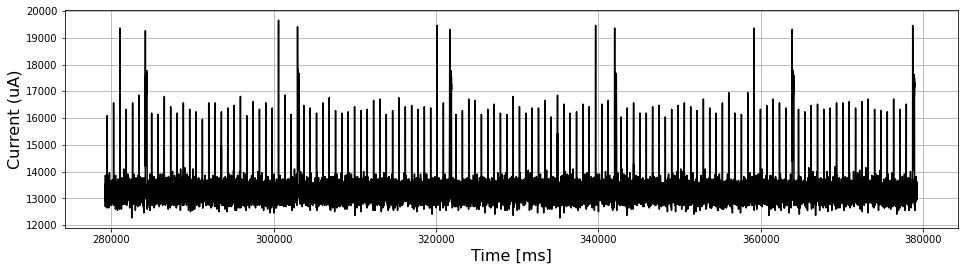

In [10]:
# the current log for three transmissions
plt.plot(energy_tx.iloc[tmp[0]:int(tmp[0]+1e5), 1], color="black")

plt.xlabel("Time [ms]", fontsize=16)
plt.ylabel("Current (uA)", fontsize=16)
plt.grid()

In [11]:
energy_tx.iloc[:int(17e5)].to_csv("ppk-17s.csv")